# **Klasifikasi Tandan Sawit**

### **Nama: Muhammad Wildan Nabila**
### **NIM : 202210370311252**
### **Kelas : Machine Learning A**


# **A. Setup**

## *1. Setup & Mount Google Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## *2. Set PATH dataset + cek struktur*

In [ ]:
import os
from pathlib import Path

DATASET_DIR = "/content/drive/MyDrive/dataset_sawit_UAP"
DATASET_DIR = Path(DATASET_DIR)

assert DATASET_DIR.exists(), f"Folder tidak ditemukan: {DATASET_DIR}"
print("✅ Dataset folder ditemukan:", DATASET_DIR)
print("Isi folder:", sorted([p.name for p in DATASET_DIR.iterdir() if p.is_dir()]))


✅ Dataset folder ditemukan: /content/drive/MyDrive/dataset_sawit_UAP
Isi folder: ['decayed', 'fully_ripe', 'immature', 'over_ripe', 'partially_ripe']


# **B. EDA**

## *1. Hitung jumlah file per kelas*

In [ ]:
import glob
import pandas as pd

class_names = sorted([p.name for p in DATASET_DIR.iterdir() if p.is_dir()])
counts = []
for c in class_names:
    n = len(glob.glob(str(DATASET_DIR / c / "*.*")))
    counts.append((c, n))

df_counts = pd.DataFrame(counts, columns=["class", "count"]).sort_values("count", ascending=False)
df_counts["percent"] = (df_counts["count"] / df_counts["count"].sum() * 100).round(2)

print("Total gambar:", df_counts["count"].sum())
df_counts


Total gambar: 4758


class  count  percent
1      fully_ripe   1519    31.93
4  partially_ripe   1405    29.53
2        immature    758    15.93
3       over_ripe    665    13.98
0         decayed    411     8.64

## *2. Visualisasi distribusi kelas*

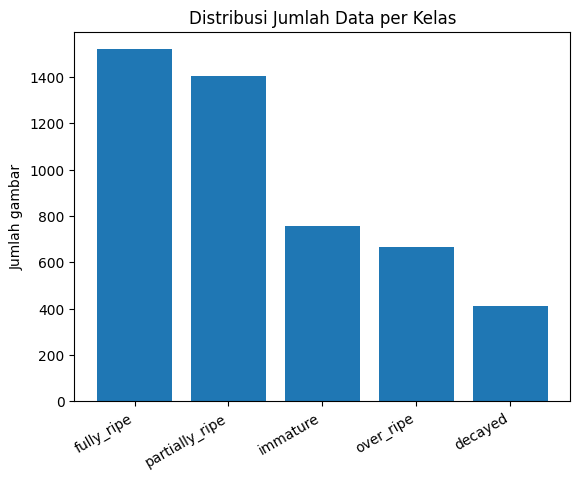

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df_counts["class"], df_counts["count"])
plt.xticks(rotation=30, ha="right")
plt.title("Distribusi Jumlah Data per Kelas")
plt.ylabel("Jumlah gambar")
plt.show()


## *3. Preview sample gambar per kelas*

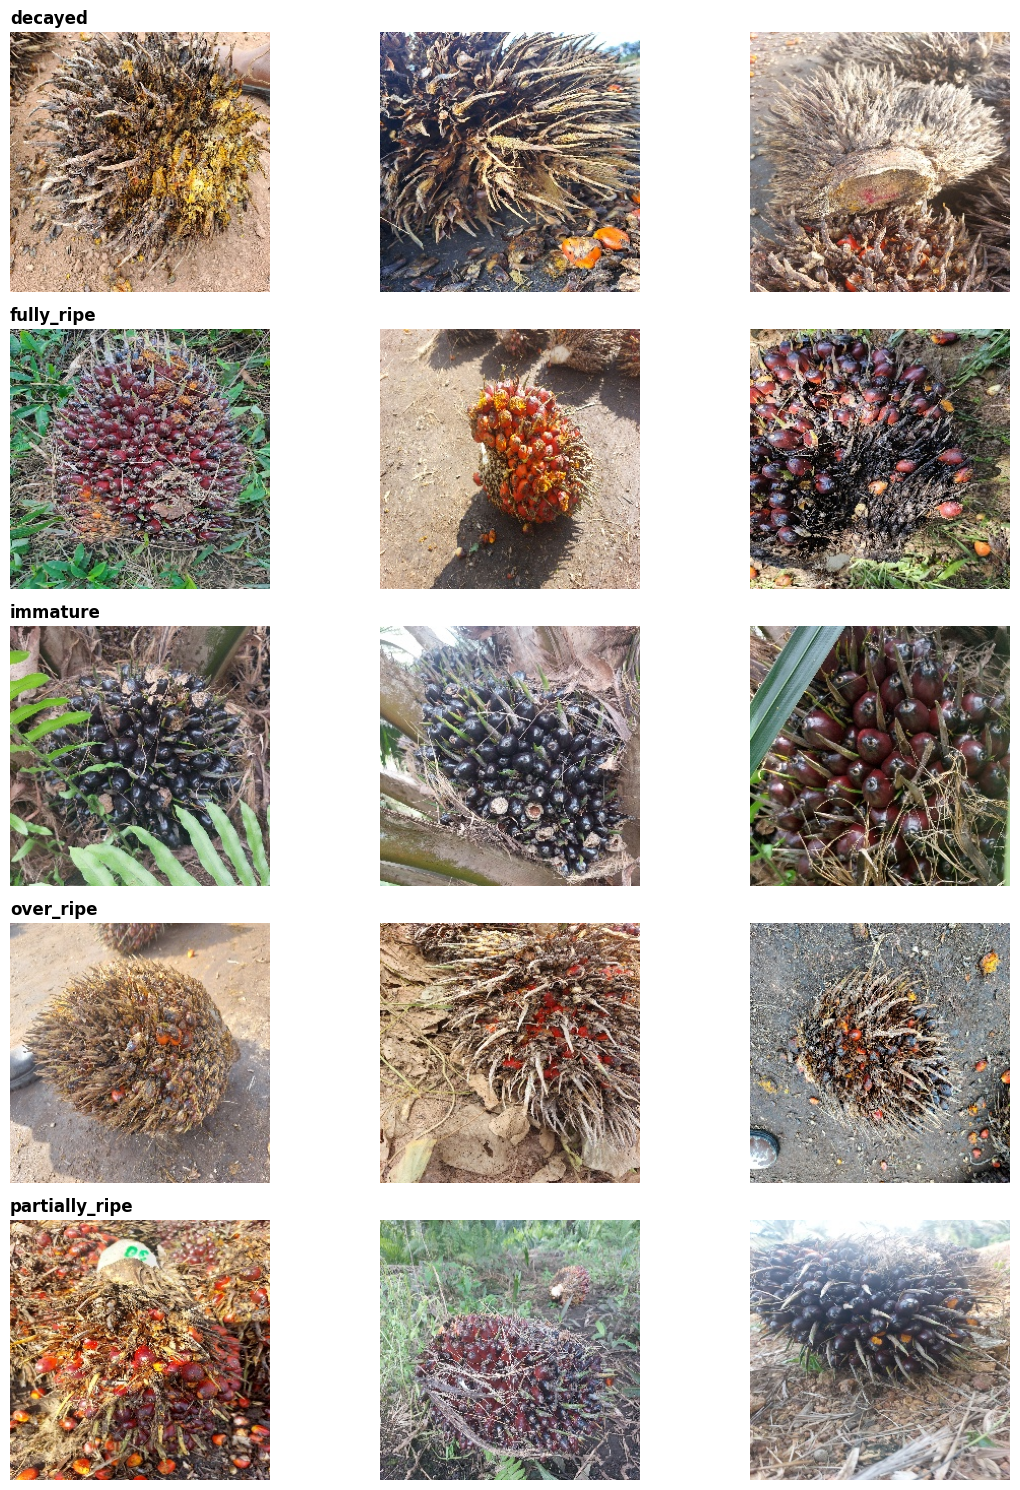

In [ ]:
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt

def show_samples_per_class(dataset_dir, class_names, n=3):
    fig, axes = plt.subplots(
        nrows=len(class_names),
        ncols=n,
        figsize=(4*n, 3*len(class_names))
    )

    if len(class_names) == 1:
        axes = [axes]

    for row, c in enumerate(class_names):
        img_paths = glob.glob(str(dataset_dir / c / "*.*"))

        if len(img_paths) == 0:
            for col in range(n):
                axes[row][col].axis("off")
            continue

        picks = random.sample(img_paths, min(n, len(img_paths)))

        for col in range(n):
            ax = axes[row][col]
            ax.axis("off")

            if col < len(picks):
                try:
                    img = Image.open(picks[col]).convert("RGB")
                    ax.imshow(img)
                except:
                    ax.text(0.5, 0.5, "Error\nLoad Image",
                            ha="center", va="center")

            if col == 0:
                ax.set_title(c, loc="left", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

show_samples_per_class(DATASET_DIR, class_names, n=3)


# **C. Preprocessing dan Split Data**

## *1. Split dataset (train/val/test)*

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import glob

all_paths = []
all_labels = []

class_to_idx = {c:i for i,c in enumerate(class_names)}

for c in class_names:
    paths = glob.glob(str(DATASET_DIR / c / "*.*"))
    all_paths.extend(paths)
    all_labels.extend([class_to_idx[c]] * len(paths))

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("Total data:", len(all_paths))

X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=42, stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", len(X_train))
print("Val  :", len(X_val))
print("Test :", len(X_test))


Total data: 4758
Train: 3330
Val  : 714
Test : 714


## *2. Cek distribusi kelas setelah split*

In [ ]:
import pandas as pd

def show_split_counts(y, split_name):
    vc = pd.Series(y).value_counts().sort_index()
    df = pd.DataFrame({
        "class": class_names,
        "count": [vc.get(i,0) for i in range(len(class_names))]
    })
    df["split"] = split_name
    return df

df_split = pd.concat([
    show_split_counts(y_train, "train"),
    show_split_counts(y_val, "val"),
    show_split_counts(y_test, "test"),
])

df_split_pivot = df_split.pivot(index="class", columns="split", values="count")
df_split_pivot


split           test  train  val
class                           
decayed           62    288   61
fully_ripe       228   1063  228
immature         113    531  114
over_ripe        100    465  100
partially_ripe   211    983  211

## *3. Augmentation*

In [ ]:
import os, glob, random, uuid
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance

SEED = 42
random.seed(SEED)

DATASET_DIR = Path(DATASET_DIR)

ADD_TARGET = {
    "decayed": 200,
    "over_ripe": 100,
}

OUT_EXT = ".jpg"

def safe_open_rgb(p):
    img = Image.open(p).convert("RGB")
    return img

def augment_pil(img: Image.Image) -> Image.Image:
    """Augmentasi realistis (tidak ekstrem, menjaga sinyal warna kematangan)."""
    if random.random() < 0.5:
        img = ImageOps.mirror(img)

    angle = random.uniform(-15, 15)
    img = img.rotate(angle, resample=Image.BILINEAR, expand=False)

    if random.random() < 0.7:
        w, h = img.size
        crop_frac = random.uniform(0.0, 0.10)
        dx = int(w * crop_frac)
        dy = int(h * crop_frac)
        left = random.randint(0, dx) if dx > 0 else 0
        top  = random.randint(0, dy) if dy > 0 else 0
        right = w - random.randint(0, dx) if dx > 0 else w
        bottom = h - random.randint(0, dy) if dy > 0 else h
        img = img.crop((left, top, right, bottom)).resize((w, h), Image.BILINEAR)

    if random.random() < 0.9:
        b = random.uniform(0.90, 1.10)
        c = random.uniform(0.90, 1.12)
        img = ImageEnhance.Brightness(img).enhance(b)
        img = ImageEnhance.Contrast(img).enhance(c)

    return img

def make_augmented_files_for_class(class_name, n_add):
    class_dir = DATASET_DIR / class_name
    assert class_dir.exists(), f"Folder kelas tidak ada: {class_dir}"

    paths = glob.glob(str(class_dir / "*.*"))
    assert len(paths) > 0, f"Tidak ada gambar di kelas {class_name}"

    created = 0
    for _ in range(n_add):
        src = random.choice(paths)
        img = safe_open_rgb(src)
        aug = augment_pil(img)

        new_name = f"aug_{class_name}_{uuid.uuid4().hex[:10]}{OUT_EXT}"
        out_path = class_dir / new_name

        aug.save(out_path, quality=90, optimize=True)
        created += 1

    return created

total_created = 0
for cls, n_add in ADD_TARGET.items():
    made = make_augmented_files_for_class(cls, n_add)
    total_created += made
    print(f"✅ Kelas {cls}: dibuat {made} file augmentasi")

print("✅ Total file augmentasi dibuat:", total_created)

✅ Kelas decayed: dibuat 200 file augmentasi
✅ Kelas over_ripe: dibuat 100 file augmentasi
✅ Total file augmentasi dibuat: 300


## *4. Cek ulang total data setelah augmentasi*

In [ ]:
import pandas as pd
import glob

counts = []
for c in class_names:
    n = len(glob.glob(str(DATASET_DIR / c / "*.*")))
    counts.append((c, n))

df_counts2 = pd.DataFrame(counts, columns=["class", "count"]).sort_values("count", ascending=False)
df_counts2["percent"] = (df_counts2["count"] / df_counts2["count"].sum() * 100).round(2)

print("✅ Total gambar setelah offline augment:", df_counts2["count"].sum())
df_counts2

✅ Total gambar setelah offline augment: 5058


class  count  percent
1      fully_ripe   1519    30.03
4  partially_ripe   1405    27.78
3       over_ripe    765    15.12
2        immature    758    14.99
0         decayed    611    12.08

## *5. Split Train/Val/Test (Stratified)*

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import glob

all_paths = []
all_labels = []

class_to_idx = {c:i for i,c in enumerate(class_names)}

for c in class_names:
    paths = glob.glob(str(DATASET_DIR / c / "*.*"))
    all_paths.extend(paths)
    all_labels.extend([class_to_idx[c]] * len(paths))

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("✅ Total data (after offline aug):", len(all_paths))

X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=42, stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", len(X_train))
print("Val  :", len(X_val))
print("Test :", len(X_test))

✅ Total data (after offline aug): 5058
Train: 3540
Val  : 759
Test : 759


## *6. Cek distribusi kelas setelah split*

In [ ]:
import pandas as pd

def split_counts(y, name):
    vc = pd.Series(y).value_counts().sort_index()
    return pd.DataFrame({
        "class": class_names,
        name: [int(vc.get(i,0)) for i in range(len(class_names))]
    })

df_split = split_counts(y_train,"train").merge(
    split_counts(y_val,"val"), on="class"
).merge(
    split_counts(y_test,"test"), on="class"
)

df_split["total"] = df_split["train"] + df_split["val"] + df_split["test"]
df_split

class  train  val  test  total
0         decayed    428   92    91    611
1      fully_ripe   1063  228   228   1519
2        immature    531  113   114    758
3       over_ripe    535  115   115    765
4  partially_ripe    983  211   211   1405

## *7. Processing Pipeline (tf.data) + Augmentasi TRAIN saja*

In [ ]:
import tensorflow as tf

IMG_SIZE = (160, 160)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

NUM_CLASSES = len(class_names)

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomContrast(0.15),
], name="augment")

def augment(img, label):
    img = data_augment(img, training=True)
    return img, label

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(len(X), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)

print("✅ Pipeline siap:", train_ds, val_ds, test_ds)


✅ Pipeline siap: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## *8. Preview batch hasil augmentasi*

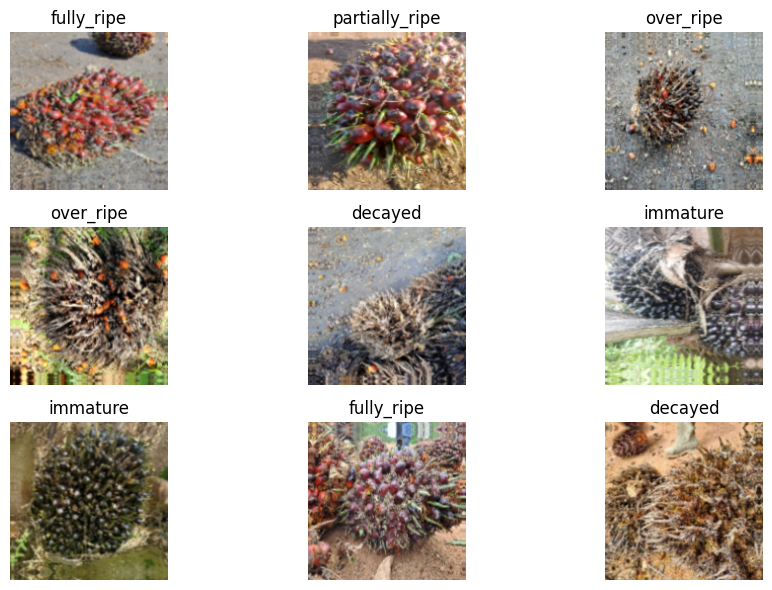

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_ds))
plt.figure(figsize=(10,6))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow((images[i]/255.0))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# **D. Build 3 Model (CNN Scratch + MobileNetV2 + EfficientNetB0)**

## *1. Class Weight untuk imbalance*

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}
class_weights


{0: 1.6542056074766356,
 1: 0.6660395108184384,
 2: 1.3333333333333333,
 3: 1.3233644859813085,
 4: 0.7202441505595117}

## *2. Helper: fungsi training + callbacks*

In [ ]:
import tensorflow as tf

def get_callbacks(model_name):
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        )
    ]

def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model


# **Da. Model A — Base CNN (Non-pretrained)**

## *1. Build model*

In [ ]:
def build_base_cnn(input_shape=(160,160,3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name="BaseCNN")
    return model

base_cnn = build_base_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)
base_cnn = compile_model(base_cnn, lr=1e-3)
base_cnn.summary()


Model: "BaseCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,405 (431.27 KB)

 Trainable params: 110,405 (431.27 KB)

 Non-trainable params: 0 (0.00 B)

## *2. Train Base CNN*

In [ ]:
history_base = base_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=get_callbacks("model_base_cnn"),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2062 - loss: 1.6208
Epoch 1: val_accuracy improved from -inf to 0.20158, saving model to model_base_cnn.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 897s 4s/step - accuracy: 0.2064 - loss: 1.6206 - val_accuracy: 0.2016 - val_loss: 1.8320 - learning_rate: 0.0010
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3225 - loss: 1.4871
Epoch 2: val_accuracy improved from 0.20158 to 0.37945, saving model to model_base_cnn.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.3226 - loss: 1.4870 - val_accuracy: 0.3794 - val_loss: 1.3867 - learning_rate: 0.0010
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4009 - loss: 1.3625
Epoch 3: val_accuracy did not improve from 0.37945
222/222 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.4010 - loss: 1.3624 - val_accuracy: 0.2754 - val_loss: 1.4361 - learning_rate: 0.0010
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4693 - loss: 1.2180


# **Db. MODEL B — MobileNetV2 (Pretrained)**

## *1. Build model*

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre

def build_mobilenetv2(input_shape=(160,160,3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)
    x = mobilenet_pre(inputs)

    base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = False

    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="MobileNetV2_TL")
    return model, base

mobilenet_model, mobilenet_base = build_mobilenetv2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=NUM_CLASSES
)
mobilenet_model = compile_model(mobilenet_model, lr=1e-3)
mobilenet_model.summary()


/tmp/ipython-input-2673461916.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 160, 160,  │          0 │ input_layer_2[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 160, 160,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## *2. Train head (freeze)*

In [ ]:
history_mnet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=get_callbacks("model_mobilenetv2"),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.4709 - loss: 1.3549
Epoch 1: val_accuracy improved from -inf to 0.70883, saving model to model_mobilenetv2.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 143s 608ms/step - accuracy: 0.4713 - loss: 1.3535 - val_accuracy: 0.7088 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.6553 - loss: 0.7649
Epoch 2: val_accuracy improved from 0.70883 to 0.72991, saving model to model_mobilenetv2.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 134s 572ms/step - accuracy: 0.6554 - loss: 0.7648 - val_accuracy: 0.7299 - val_loss: 0.6035 - learning_rate: 0.0010
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7058 - loss: 0.6820
Epoch 3: val_accuracy improved from 0.72991 to 0.73386, saving model to model_mobilenetv2.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 126s 566ms/step - accuracy: 0.7058 - loss: 0.6819 - val_accuracy: 0.7339 - val_loss: 0.6284 - learning_rate: 0.0010
Epoch 4/10
222/2

## *3. Fine-tune*

In [ ]:
mobilenet_base.trainable = True
for layer in mobilenet_base.layers[:-30]:
    layer.trainable = False

mobilenet_model = compile_model(mobilenet_model, lr=1e-4)

history_mnet_ft = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks("model_mobilenetv2_ft"),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.6634 - loss: 0.7565
Epoch 1: val_accuracy improved from -inf to 0.73386, saving model to model_mobilenetv2_ft.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 176s 743ms/step - accuracy: 0.6636 - loss: 0.7561 - val_accuracy: 0.7339 - val_loss: 0.7031 - learning_rate: 1.0000e-04
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7608 - loss: 0.5185
Epoch 2: val_accuracy improved from 0.73386 to 0.79842, saving model to model_mobilenetv2_ft.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 165s 740ms/step - accuracy: 0.7608 - loss: 0.5185 - val_accuracy: 0.7984 - val_loss: 0.5222 - learning_rate: 1.0000e-04
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7915 - loss: 0.4272
Epoch 3: val_accuracy improved from 0.79842 to 0.81291, saving model to model_mobilenetv2_ft.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 170s 760ms/step - accuracy: 0.7915 - loss: 0.4272 - val_accuracy: 0.8129 - val_loss: 0.5278 - learning_rate: 1.0000e-0

# **Dc. MODEL C — EfficientNetB0 (Pretrained)**

## *1. Build model*

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre

def build_efficientnetb0(input_shape=(160,160,3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)
    x = eff_pre(inputs)

    base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = False

    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_TL")
    return model, base

eff_model, eff_base = build_efficientnetb0(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=NUM_CLASSES
)
eff_model = compile_model(eff_model, lr=1e-3)
eff_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EfficientNetB0_TL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 160, 160,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 160, 160,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 161, 161,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 80, 80,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 80, 80,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 80, 80,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 80, 80,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 80, 80,    │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## *2. Train head (freeze)*

In [ ]:
history_eff = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=get_callbacks("model_efficientnetb0"),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.5069 - loss: 1.1412
Epoch 1: val_accuracy improved from -inf to 0.74440, saving model to model_efficientnetb0.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.5073 - loss: 1.1403 - val_accuracy: 0.7444 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.6900 - loss: 0.7216
Epoch 2: val_accuracy did not improve from 0.74440
222/222 ━━━━━━━━━━━━━━━━━━━━ 213s 955ms/step - accuracy: 0.6902 - loss: 0.7214 - val_accuracy: 0.7312 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.7433 - loss: 0.6094
Epoch 3: val_accuracy improved from 0.74440 to 0.76021, saving model to model_efficientnetb0.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 185s 830ms/step - accuracy: 0.7433 - loss: 0.6094 - val_accuracy: 0.7602 - val_loss: 0.6072 - learning_rate: 0.0010
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - ac

## *3. Fine-tune*

In [ ]:
eff_base.trainable = True
for layer in eff_base.layers[:-20]:
    layer.trainable = False

eff_model = compile_model(eff_model, lr=1e-4)

history_eff_ft = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=get_callbacks("model_efficientnetb0_ft"),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.6710 - loss: 0.7365
Epoch 1: val_accuracy improved from -inf to 0.80237, saving model to model_efficientnetb0_ft.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 227s 952ms/step - accuracy: 0.6711 - loss: 0.7363 - val_accuracy: 0.8024 - val_loss: 0.5308 - learning_rate: 1.0000e-04
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7728 - loss: 0.5427
Epoch 2: val_accuracy did not improve from 0.80237
222/222 ━━━━━━━━━━━━━━━━━━━━ 209s 936ms/step - accuracy: 0.7728 - loss: 0.5426 - val_accuracy: 0.7918 - val_loss: 0.5224 - learning_rate: 1.0000e-04
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8050 - loss: 0.4444
Epoch 3: val_accuracy improved from 0.80237 to 0.82740, saving model to model_efficientnetb0_ft.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 208s 936ms/step - accuracy: 0.8050 - loss: 0.4444 - val_accuracy: 0.8274 - val_loss: 0.4784 - learning_rate: 1.0000e-04
Epoch 4/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 0

# **E. Evaluasi**

## *1. Helper: plot training (acc & loss)*

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model"):
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


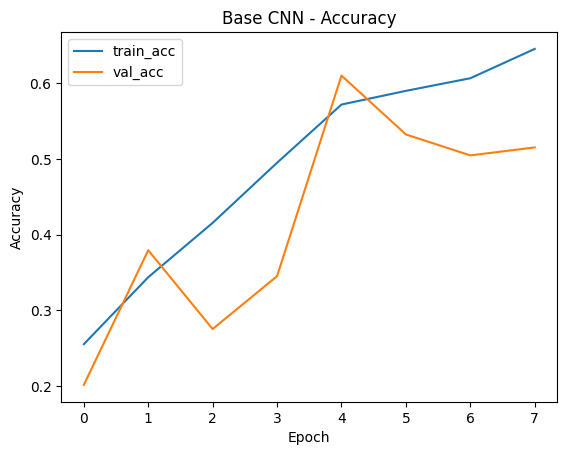

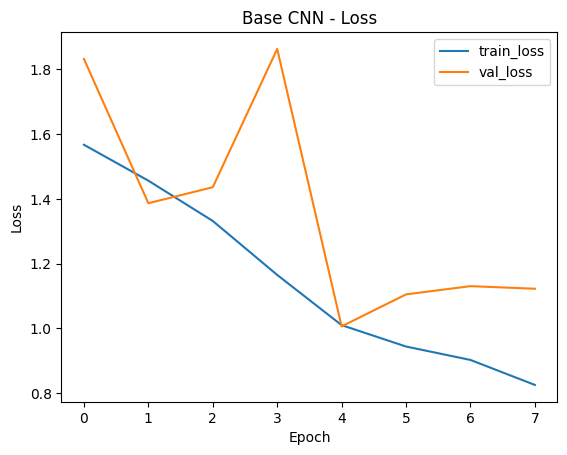

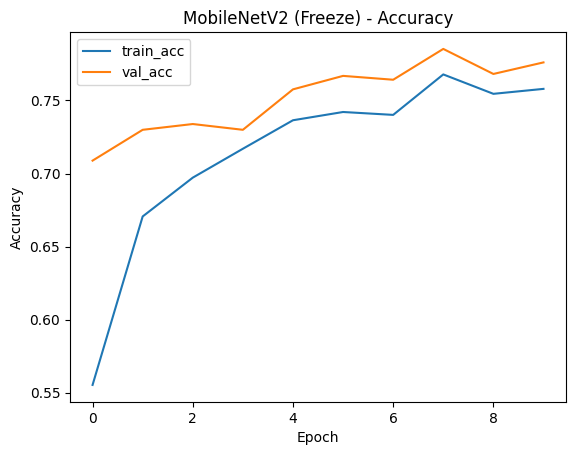

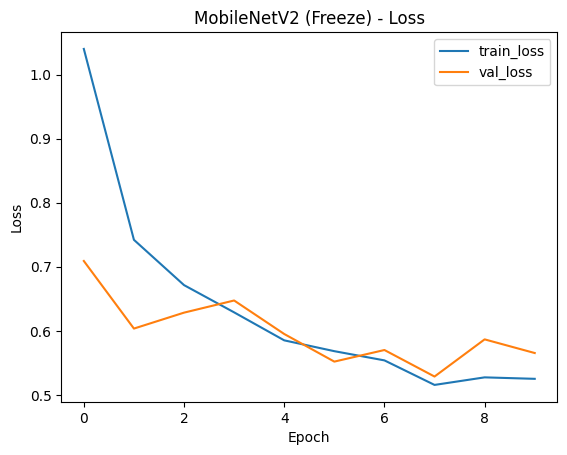

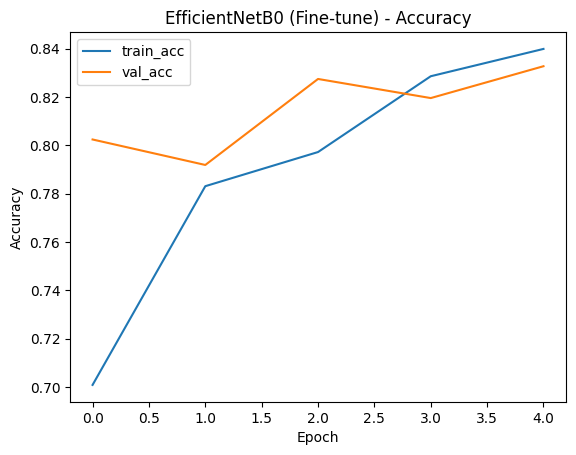

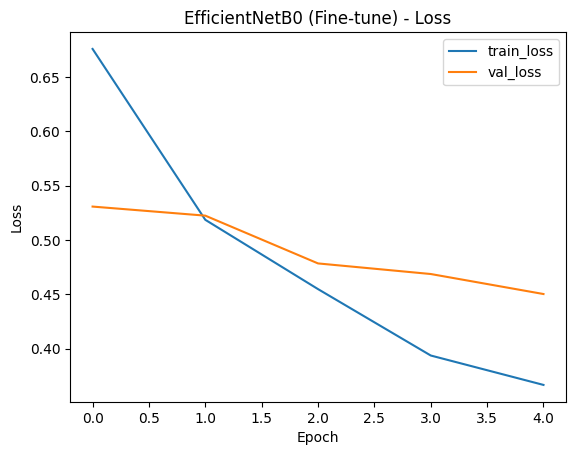

In [ ]:
plot_history(history_base, "Base CNN")
plot_history(history_mnet, "MobileNetV2 (Freeze)")
plot_history(history_eff_ft, "EfficientNetB0 (Fine-tune)")

## *2. Helper: evaluasi test set + report + confusion matrix*

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, test_ds, class_names, title="Model"):
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
    y_prob = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print(f"\n===== {title}: Classification Report (TEST) =====")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.title(f"{title} - Confusion Matrix (TEST)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    acc = (y_pred == y_true).mean()
    return acc, cm


## *3. Load model terbaik checkpoint*

In [ ]:
import tensorflow as tf

base_best = tf.keras.models.load_model("model_base_cnn.keras")
mnet_best = tf.keras.models.load_model("model_mobilenetv2.keras")
eff_best  = tf.keras.models.load_model("model_efficientnetb0_ft.keras")


## *4. Jalankan evaluasi test set*


===== Base CNN: Classification Report (TEST) =====
                precision    recall  f1-score   support

       decayed     0.8049    0.7253    0.7630        91
    fully_ripe     0.5531    0.7544    0.6382       228
      immature     0.6132    0.5702    0.5909       114
     over_ripe     0.5437    0.7565    0.6327       115
partially_ripe     0.7300    0.3460    0.4695       211

      accuracy                         0.6100       759
     macro avg     0.6490    0.6305    0.6189       759
  weighted avg     0.6401    0.6100    0.5983       759



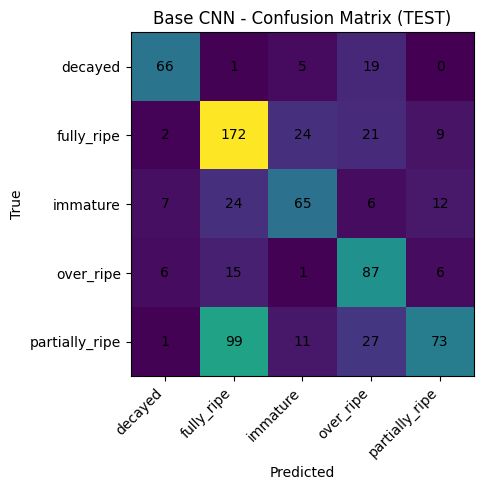


===== MobileNetV2 (Freeze): Classification Report (TEST) =====
                precision    recall  f1-score   support

       decayed     0.9310    0.8901    0.9101        91
    fully_ripe     0.6848    0.7719    0.7258       228
      immature     0.8426    0.7982    0.8198       114
     over_ripe     0.7339    0.7913    0.7615       115
partially_ripe     0.7432    0.6445    0.6904       211

      accuracy                         0.7576       759
     macro avg     0.7871    0.7792    0.7815       759
  weighted avg     0.7617    0.7576    0.7576       759



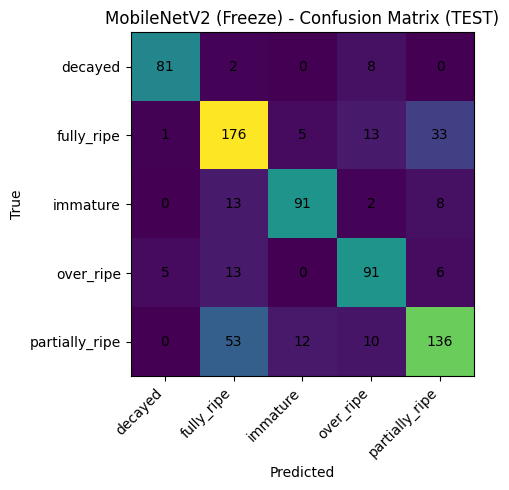


===== EfficientNetB0 (Fine-tune): Classification Report (TEST) =====
                precision    recall  f1-score   support

       decayed     0.9263    0.9670    0.9462        91
    fully_ripe     0.7298    0.9123    0.8109       228
      immature     0.8899    0.8509    0.8700       114
     over_ripe     0.8347    0.8783    0.8559       115
partially_ripe     0.8658    0.6114    0.7167       211

      accuracy                         0.8208       759
     macro avg     0.8493    0.8440    0.8399       759
  weighted avg     0.8311    0.8208    0.8166       759



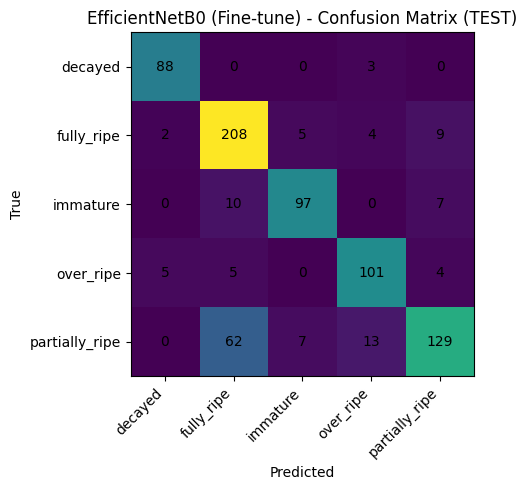

TEST Accuracy:
Base CNN: 0.6100131752305665
MobileNetV2: 0.7575757575757576
EfficientNetB0: 0.8208168642951251


In [ ]:
acc_base, cm_base = evaluate_model(base_best, test_ds, class_names, "Base CNN")
acc_mnet, cm_mnet = evaluate_model(mnet_best, test_ds, class_names, "MobileNetV2 (Freeze)")
acc_eff,  cm_eff  = evaluate_model(eff_best,  test_ds, class_names, "EfficientNetB0 (Fine-tune)")

print("TEST Accuracy:")
print("Base CNN:", acc_base)
print("MobileNetV2:", acc_mnet)
print("EfficientNetB0:", acc_eff)


# **F. Testing gambar baru (lokal / upload)**

In [ ]:
import numpy as np
from PIL import Image

def predict_image(model, img_path, class_names, img_size=(160,160)):
    img = Image.open(img_path).convert("RGB").resize(img_size)
    x = np.array(img).astype("float32")
    x = np.expand_dims(x, axis=0)  # (1,H,W,3)

    prob = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(prob))
    return class_names[pred_idx], float(prob[pred_idx]), prob

# contoh pakai:
# label, conf, prob = predict_image(eff_best, "/content/drive/MyDrive/tes1.jpg", class_names, IMG_SIZE)
# print(label, conf)


## *1. Upload gambar baru langsung*

In [ ]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())


Saving FullyRipe1488.jpg to FullyRipe1488.jpg
Saving OverRipe664.jpg to OverRipe664.jpg
Saving Decayed410.jpg to Decayed410 (1).jpg
Saving Immature758.jpg to Immature758.jpg
Saving PartiallyRipe1404.jpg to PartiallyRipe1404 (1).jpg


['FullyRipe1488.jpg',
 'OverRipe664.jpg',
 'Decayed410 (1).jpg',
 'Immature758.jpg',
 'PartiallyRipe1404 (1).jpg']

## *2. Prediksi gambar upload pakai model terbaik (EfficientNetB0)*

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf

eff_best = tf.keras.models.load_model("model_efficientnetb0_ft.keras")

def predict_image_any(model, img_pil, class_names, img_size=(160,160)):
    img = img_pil.convert("RGB").resize(img_size)
    x = np.array(img).astype("float32")
    x = np.expand_dims(x, axis=0)
    prob = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(prob))
    return class_names[pred_idx], float(prob[pred_idx]), prob

# coba prediksi semua file yang diupload
for fn in uploaded.keys():
    img = Image.open(fn)
    pred, conf, prob = predict_image_any(eff_best, img, class_names, IMG_SIZE)
    print(f"{fn} -> {pred} (conf={conf:.3f})")


FullyRipe1488.jpg -> fully_ripe (conf=0.767)
OverRipe664.jpg -> over_ripe (conf=0.886)
Decayed410 (1).jpg -> decayed (conf=0.964)
Immature758.jpg -> immature (conf=0.913)
PartiallyRipe1404 (1).jpg -> fully_ripe (conf=0.645)


## *3. Tampilkan Top-3 probabilitas*

In [ ]:
import numpy as np

def show_topk(prob, class_names, k=3):
    idx = np.argsort(prob)[::-1][:k]
    for i in idx:
        print(f"- {class_names[i]}: {prob[i]:.3f}")

# contoh satu gambar
fn = list(uploaded.keys())[0]
img = Image.open(fn)
pred, conf, prob = predict_image_any(eff_best, img, class_names, IMG_SIZE)
print("Pred:", pred, "Conf:", conf)
show_topk(prob, class_names, k=3)


Pred: fully_ripe Conf: 0.7666923403739929
- fully_ripe: 0.767
- partially_ripe: 0.210
- immature: 0.016


# **G. Deploy Website Streamlit**

## *1. Dari Colab → Download model & class_names*

In [ ]:
import json, zipfile, os

class_names_path = "class_names.json"
with open(class_names_path, "w") as f:
    json.dump(class_names, f)

files_to_zip = [
    "model_base_cnn.keras",
    "model_mobilenetv2.keras",
    "model_efficientnetb0_ft.keras",
    "class_names.json"
]

zip_name = "sawit_models.zip"
with zipfile.ZipFile(zip_name, "w") as z:
    for fp in files_to_zip:
        if os.path.exists(fp):
            z.write(fp)
        else:
            print("⚠️ tidak ditemukan:", fp)

print("✅ siap download:", zip_name)


✅ siap download: sawit_models.zip
